In [287]:
import torch
import os
from torch.utils.data import TensorDataset,ConcatDataset,DataLoader
import matplotlib.pyplot as plt
from torch import nn
from torch.nn.functional import relu
from tqdm import tqdm
from sklearn.preprocessing import RobustScaler
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

device = 'cuda'
conditions = ['PF','Vehicle']
path_to_pt_ekyn = f'../pt_ekyn'
path_to_pt_snezana_mice = f'../pt_snezana_mice'

ekyn_ids = sorted(set([recording_filename.split('_')[0] for recording_filename in os.listdir(path_to_pt_ekyn)]))
snezana_mice_ids = sorted(set([recording_filename.split('.')[0] for recording_filename in os.listdir(path_to_pt_snezana_mice)]))
print(len(ekyn_ids),ekyn_ids)
print(len(snezana_mice_ids),snezana_mice_ids)

def load_ekyn(id,condition):
    X,y = torch.load(f'{path_to_pt_ekyn}/{id}_{condition}.pt',weights_only=False)
    return X,y
def load_snezana_mice(id):
    X,y = torch.load(f'{path_to_pt_snezana_mice}/{id}.pt',weights_only=False)
    return X,y

class EEGDataset(torch.utils.data.Dataset):
    def __init__(self, id, condition):
        self.X,self.y= load_ekyn(id=id,condition=condition)
        self.X = self.X.unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx],self.y[idx]
    
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=1)
        self.convs = nn.ModuleList([nn.Conv1d(64, 64, kernel_size=3, stride=2, padding=1) for _ in range(2)])  # Reduced from 8
        self.dropout = nn.Dropout(0.5)  # Added regularization

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.dropout(x)
        x = torch.relu(self.conv2(x))
        x = self.dropout(x)
        for conv in self.convs:
            x = torch.relu(conv(x))
            x = self.dropout(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.convs = nn.ModuleList([nn.ConvTranspose1d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1) for _ in range(2)])  # Reduced from 8
        self.conv5 = nn.ConvTranspose1d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv6 = nn.ConvTranspose1d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, original_length=5000):
        for conv in self.convs:
            x = torch.relu(conv(x))
            x = self.dropout(x)
        x = torch.relu(self.conv5(x))
        x = self.conv6(x)
        if x.size(-1) != original_length:
            x = x[:, :, :original_length] if x.size(-1) > original_length else nn.functional.pad(x, (0, original_length - x.size(-1)))
        return x

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        original_length = x.size(-1)  # Capture input length
        x = self.encoder(x)
        x = self.decoder(x, original_length=original_length)
        return x

    
traindataset = ConcatDataset([EEGDataset(id=id,condition='PF') for id in ekyn_ids[:1]])
testdataset  = ConcatDataset([EEGDataset(id='A1-1',condition='PF')])

trainloader = DataLoader(traindataset, batch_size=512, shuffle=True)
testloader = DataLoader(testdataset, batch_size=512, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = Autoencoder()
optimizer = torch.optim.AdamW(autoencoder.parameters(),lr=3e-3)
criterion = nn.MSELoss()

print(device)

Xi,yi = next(iter(trainloader))
z = autoencoder.encoder(Xi)
print(z.shape)
autoencoder.decoder(z).shape

16 ['A1-0', 'A1-1', 'A4-0', 'B1-0', 'B3-1', 'C1-0', 'C4-0', 'C4-1', 'D1-0', 'E1-0', 'E2-1', 'E4-0', 'E4-1', 'F1-0', 'F1-1', 'F5-1']
58 ['21-HET-1', '21-HET-10', '21-HET-11', '21-HET-12', '21-HET-13', '21-HET-2', '21-HET-3', '21-HET-4', '21-HET-5', '21-HET-7', '21-HET-8', '21-HET-9', '21-KO-1', '21-KO-10', '21-KO-11', '21-KO-12', '21-KO-2', '21-KO-3', '21-KO-4', '21-KO-5', '21-KO-6', '21-KO-7', '21-KO-8', '21-KO-9', '21-WK-1', '21-WK-10', '21-WK-11', '21-WK-12', '21-WK-13', '21-WK-15', '21-WK-16', '21-WK-17', '21-WK-18', '21-WK-2', '21-WK-3', '21-WK-4', '21-WK-5', '21-WK-6', '21-WK-8', '21-WK-9', '21-WT-1', '21-WT-10', '21-WT-12', '21-WT-13', '21-WT-2', '21-WT-3', '21-WT-4', '21-WT-5', '21-WT-6', '21-WT-7', '21-WT-8', '21-WT-9', '354', '378', '381', '382', '386', '429']
cuda
torch.Size([512, 64, 313])


torch.Size([512, 1, 5000])

In [291]:
autoencoder.to(device)
autoencoder.train()

lossi = []
for Xi,yi in tqdm(trainloader):
    Xi,yi = Xi.to(device),yi.to(device)    
    logits = autoencoder(Xi)
    optimizer.zero_grad()
    loss = criterion(logits,Xi)
    loss.backward()
    optimizer.step()
    lossi.append(loss.item())
loss

100%|██████████| 17/17 [00:01<00:00, 12.68it/s]


tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward0>)

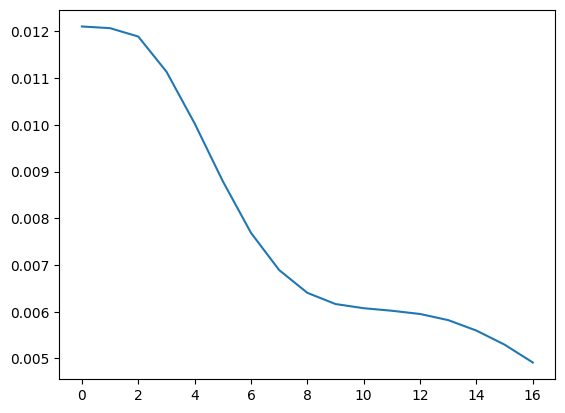

In [292]:
plt.plot(lossi)

<Axes: xlabel='0', ylabel='1'>

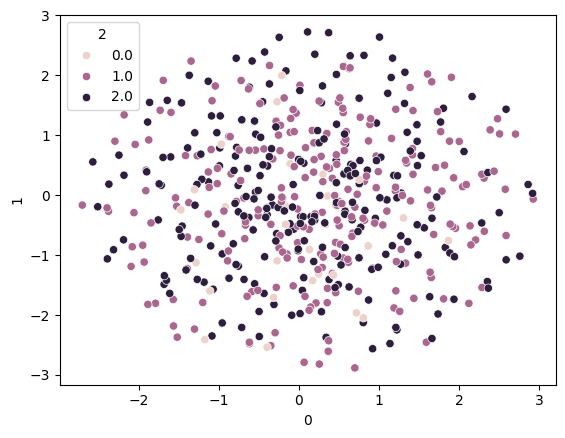

In [293]:
from sklearn.manifold import TSNE
import pandas as pd
tsne = TSNE()
Xi,yi = next(iter(trainloader))
Xi,yi = Xi.to(device),yi.to(device)
Xi_tsne = tsne.fit_transform(autoencoder.encoder(Xi).flatten(1,2).detach().cpu())
df = pd.DataFrame(torch.hstack([torch.from_numpy(Xi_tsne),yi.detach().cpu().argmax(dim=1,keepdim=True)]))
sns.scatterplot(data=df,x=0,y=1,hue=2)

In [112]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, noise_dim, output_channels=64, output_time_steps=1250):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.output_channels = output_channels
        self.output_time_steps = output_time_steps
        
        # Define the MLP layers
        self.fc1 = nn.Linear(noise_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, output_channels * output_time_steps)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Input: [batch_size, noise_dim]
        x = torch.relu(self.fc2(x))  # Hidden layers
        x = self.fc3(x)              # Output: [batch_size, 64*1250]
        x = x.view(-1, self.output_channels, self.output_time_steps)  # Reshape to [batch_size, 64, 1250]
        return x


def compute_mmd(x, y, sigma=1.0):
    def gaussian_kernel(a, b, sigma):
        a_sq = torch.sum(a ** 2, dim=1).view(-1, 1)
        b_sq = torch.sum(b ** 2, dim=1).view(1, -1)
        return torch.exp(- (a_sq - 2 * torch.mm(a, b.t()) + b_sq) / (2 * sigma ** 2))

    k_xx = gaussian_kernel(x, x, sigma)
    k_yy = gaussian_kernel(y, y, sigma)
    k_xy = gaussian_kernel(x, y, sigma)

    mmd = k_xx.mean() + k_yy.mean() - 2 * k_xy.mean()
    return mmd

# Extract paradoxical latent vectors
def extract_paradoxical_latents(autoencoder, train_loader, device='cpu'):
    autoencoder.eval()  # Set to evaluation mode
    paradoxical_latents = []

    with torch.no_grad():  # Disable gradient computation
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            labels = labels.argmax(dim=1)
            # Filter paradoxical samples (label 0)
            paradoxical_mask = (labels == 0)
            if paradoxical_mask.sum() > 0:  # If there are any paradoxical samples in the batch
                paradoxical_data = data[paradoxical_mask]  # [num_paradoxical, 1, 128]
                latent = autoencoder.encoder(paradoxical_data)  # [num_paradoxical, 64, 32]
                paradoxical_latents.append(latent.cpu())  # Move to CPU to save GPU memory

    # Concatenate all latent vectors
    if paradoxical_latents:
        paradoxical_latents = torch.cat(paradoxical_latents, dim=0)  # [total_paradoxical, 64, 32]
    else:
        paradoxical_latents = torch.tensor([])  # Empty tensor if no paradoxical samples

    return paradoxical_latents

In [113]:
noise_dim = 100  # Example noise dimension
generator = Generator(noise_dim=noise_dim)
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)

torch.Size([538, 64, 1250])

In [126]:
mmd_lossi = []
generator.to(device)
generator.train()

for i in range(20):
    paradoxical_latent = extract_paradoxical_latents(autoencoder, trainloader, device)

    noise = torch.randn(512, noise_dim,device=device)
    synthetic_latent = generator(noise).cpu()
    mmd_loss = compute_mmd(paradoxical_latent.flatten(1,2), synthetic_latent.flatten(1,2), sigma=1.0)
    gen_optimizer.zero_grad()
    mmd_loss.backward()
    gen_optimizer.step()
    mmd_lossi.append(mmd_loss.item())

KeyboardInterrupt: 

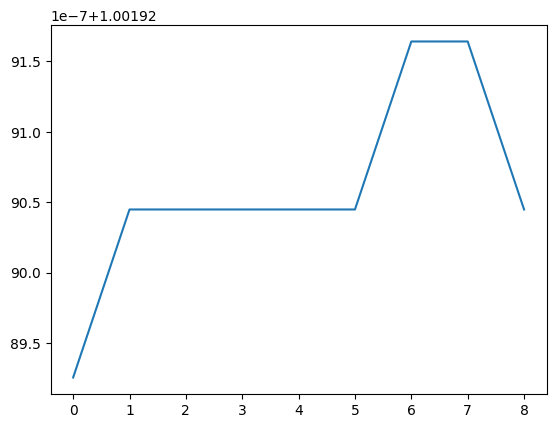

In [127]:
plt.plot(mmd_lossi)

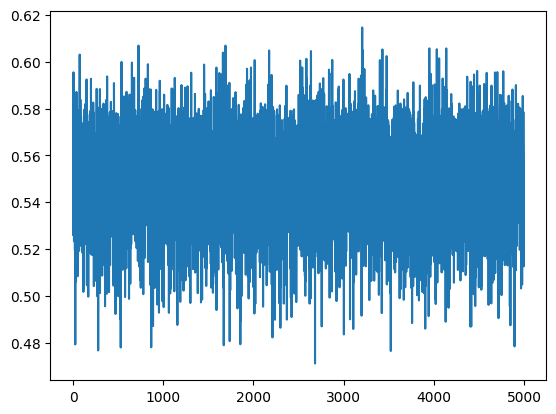

In [171]:
# Generate synthetic data
num_synthetic = 50  # Number of synthetic samples to generate
noise = torch.randn(num_synthetic, noise_dim, device=device)
synthetic_latent = generator(noise)  # [num_synthetic, 64, 1250]
synthetic_eeg = autoencoder.decoder(synthetic_latent)
plt.plot(synthetic_eeg[0].T.cpu().detach())

In [ ]:


def compute_mmd(source, target, kernel_sigma=1.0):
    """
    Compute MMD between source and target latent features using a Gaussian kernel.
    Args:
        source: Tensor of shape (batch_size, feature_dim), e.g., (32, 64)
        target: Tensor of shape (batch_size, feature_dim), e.g., (32, 64)
        kernel_sigma: Bandwidth of the Gaussian kernel
    Returns:
        MMD loss (scalar)
    """
    # Number of samples
    n_source = source.size(0)
    n_target = target.size(0)

    # Compute pairwise distances
    xx = torch.cdist(source, source, p=2) ** 2  # Source-Source distances
    yy = torch.cdist(target, target, p=2) ** 2  # Target-Target distances
    xy = torch.cdist(source, target, p=2) ** 2  # Source-Target distances

    # Gaussian kernel: exp(-distance^2 / sigma^2)
    scale = 2 * (kernel_sigma ** 2)
    k_xx = torch.exp(-xx / scale)
    k_yy = torch.exp(-yy / scale)
    k_xy = torch.exp(-xy / scale)

    # MMD: mean of kernel terms
    mmd = k_xx.mean() + k_yy.mean() - 2 * k_xy.mean()
    return mmd

